# 1. Poverty evolution since the 80s

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
povcalnet_server = 'http://iresearch.worldbank.org/PovcalNet/PovcalNetAPI.ashx?'

In [22]:
povcalnet_query = 'Countries=all&GroupedBy=WB&YearSelected=all&PovertyLine=3.2&format=csv'

In [23]:
loc = povcalnet_server + povcalnet_query
loc

'http://iresearch.worldbank.org/PovcalNet/PovcalNetAPI.ashx?Countries=all&GroupedBy=WB&YearSelected=all&PovertyLine=3.2&format=csv'

In [25]:
df = pd.read_csv(loc,delimiter= ',')

In [26]:
df.columns

Index(['requestYear', 'regionTitle', 'regionCID', 'povertyLine', 'mean', 'hc',
       'pg', 'p2', 'population'],
      dtype='object')

In [41]:
df.rename(columns={'hc':'headcount'}, inplace=True)
df.rename(columns={'requestYear':'Year'}, inplace=True)
df.headcount = df.headcount*100

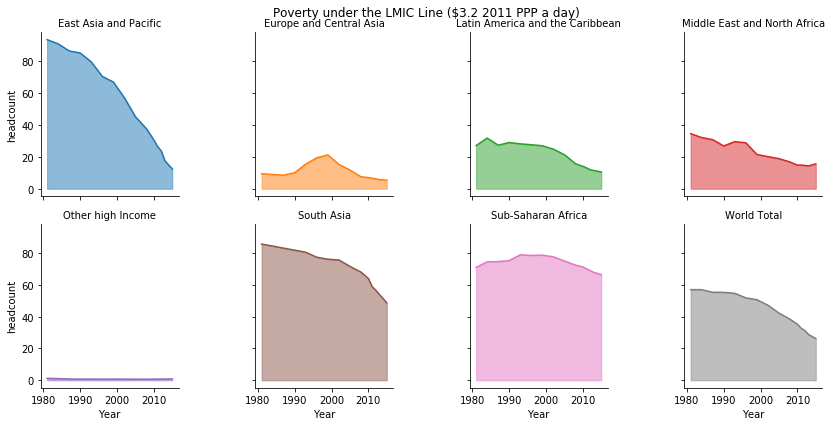

In [44]:
# Mostly taken from https://python-graph-gallery.com/242-area-chart-and-faceting/
# Create a grid of 4 columns
g = sns.FacetGrid(df, col='regionTitle', hue='regionTitle', col_wrap=4,)
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'headcount')
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'headcount', alpha=0.5).set_titles("{col_name} Region")
# Titles
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Poverty under the LMIC Line ($3.2 2011 PPP a day) ')


## Best Performers in each region

In [1]:
povcalnet_query = 'refyears=all&display=c&groupedby=wb&Countries=all&PovertyLine=3.2&format=csv'

In [4]:
loc = povcalnet_server + povcalnet_query

In [5]:
df = pd.read_csv(loc,delimiter= ',')

In [6]:
save_old = df

In [7]:
df = save_old

In [8]:
#Rename certain things
df.rename(columns={'RequestYear':'Year'}, inplace=True)
df.HeadCount = df.HeadCount*100
#Remove duplicates
df.drop_duplicates(subset ={"Year","CountryCode"}, keep = False, inplace = True) 
#From 2000 only
df = df.loc[df.Year>2000]

In [9]:
# Some countries are outlayers
df = df.loc[df.CountryCode != 'HTI']
df = df.loc[df.CountryCode != 'MUS']
# Population of poor
df = df.assign(poorpop =  df.ReqYearPopulation*df.HeadCount/100)

In [10]:
#Poor population in 2000 and 2015
df_2015 = df[df.Year==2015]
df_2015 = df_2015[['CountryCode','HeadCount']].rename(columns={'HeadCount':'poorpop2015'})
df_2002 = df[df.Year==2002]
df_2002 = df_2002[['CountryCode','HeadCount']]
df_2002 = df_2002[['CountryCode','HeadCount']].rename(columns={'HeadCount':'poorpop2002'})
df = pd.merge(df, df_2015, how='right', on='CountryCode')
df = pd.merge(df, df_2002, how='right', on='CountryCode')


In [11]:
#Percentage improvement in Poverty rate
df = df.assign(improvement =  df.poorpop2015/df.poorpop2002 )
#If the improvement more than 0.95, then delete this country
df = df.loc[df.improvement > 0.10]

In [12]:
# Best in region is the one with minimum improvement
df['imp_min'] = df.groupby(['RegionCode'])['improvement'].transform(min)
df['best'] = df['imp_min'] == df['improvement']


In [13]:
# These are the best Performers
df_bc = df[(df.best==True) & (df.Year ==2002)]

In [14]:
df_bc

,isInterpolated,useMicroData,CountryCode,CountryName,RegionCode,CoverageType,Year,DataYear,DataType,PPP,...,Decile7,Decile8,Decile9,Decile10,poorpop,poorpop2015,poorpop2002,improvement,imp_min,best
8,1.0,0.0,DZA,Algeria,MNA,N,2002.0,NaN,X,31.772290,...,-1.00000,-1.0000,-1.0000,-1.0000,5.867619,2.718500,18.339150,0.148235,0.148235,True
104,0.0,1.0,BTN,Bhutan,SAS,N,2002.0,2003.0,X,16.962910,...,0.09501,0.1182,0.1573,0.3222,0.319613,7.592676,52.706710,0.144055,0.144055,True
744,0.0,1.0,MNG,Mongolia,EAP,N,2002.0,2002.0,X,590.330000,...,0.10490,0.1261,0.1583,0.2463,0.820923,4.143251,33.594000,0.123333,0.123333,True
888,0.0,1.0,POL,Poland,ECA,N,2002.0,2002.0,X,1.936326,...,0.10160,0.1210,0.1518,0.2673,0.627681,0.234522,1.641839,0.142841,0.142841,True
1024,0.0,1.0,SDN,Sudan,SSA,N,2002.0,2009.0,X,1.485530,...,0.10370,0.1250,0.1569,0.2669,17.265115,26.522280,60.200060,0.440569,0.440569,True
1168,0.0,1.0,GBR,United Kingdom,OHI,N,2002.0,2004.0,Y,0.756404,...,0.10190,0.1209,0.1526,0.2774,0.435762,0.229204,0.733970,0.312280,0.312280,True
1184,1.0,1.0,URY,Uruguay,LAC,N,2002.0,NaN,Y,16.423850,...,-1.00000,-1.0000,-1.0000,-1.0000,0.150744,0.635796,4.529873,0.140356,0.140356,True


In [15]:
#Delete OHI
df = df.loc[df.RegionCode != 'OHI']
#Keep 2002
df_bc = df[(df.best==True) & (df.Year ==2002)]

In [16]:
#Use best performers info to label them in the graph
df_bc
col_order = df_bc['RegionCode']
best_performers = df_bc['CountryName']
best_performers_location = df_bc['poorpop2015']



In [17]:
df['Year'] = df['Year'].astype(str)


In [19]:
df['Year'] = [string.split('.')[0] for string in df.Year]


In [22]:
df['Year'] = df['Year'].astype(int)


In [23]:
df

,isInterpolated,useMicroData,CountryCode,CountryName,RegionCode,CoverageType,Year,DataYear,DataType,PPP,...,Decile7,Decile8,Decile9,Decile10,poorpop,poorpop2015,poorpop2002,improvement,imp_min,best
0,0.0,1.0,ALB,Albania,ECA,N,2002,2002.00,X,58.168010,...,0.10230,0.1198,0.1493,0.2544,0.518082,4.805442,16.980680,0.282995,0.142841,False
1,0.0,1.0,ALB,Albania,ECA,N,2005,2005.00,X,58.168010,...,0.10370,0.1213,0.1483,0.2434,0.329111,4.805442,16.980680,0.282995,0.142841,False
2,0.0,1.0,ALB,Albania,ECA,N,2008,2008.00,X,58.168010,...,0.10300,0.1193,0.1454,0.2446,0.192930,4.805442,16.980680,0.282995,0.142841,False
3,1.0,1.0,ALB,Albania,ECA,N,2010,NaN,X,58.168010,...,-1.00000,-1.0000,-1.0000,-1.0000,0.222787,4.805442,16.980680,0.282995,0.142841,False
4,1.0,1.0,ALB,Albania,ECA,N,2011,NaN,X,58.168010,...,-1.00000,-1.0000,-1.0000,-1.0000,0.218278,4.805442,16.980680,0.282995,0.142841,False
5,0.0,1.0,ALB,Albania,ECA,N,2012,2012.00,X,58.168010,...,0.10520,0.1229,0.1489,0.2293,0.222509,4.805442,16.980680,0.282995,0.142841,False
6,0.0,1.0,ALB,Albania,ECA,N,2013,2012.00,X,58.168010,...,0.10520,0.1229,0.1489,0.2293,0.189850,4.805442,16.980680,0.282995,0.142841,False
7,0.0,1.0,ALB,Albania,ECA,N,2015,2012.00,X,58.168010,...,0.10520,0.1229,0.1489,0.2293,0.138431,4.805442,16.980680,0.282995,0.142841,False
8,1.0,0.0,DZA,Algeria,MNA,N,2002,NaN,X,31.772290,...,-1.00000,-1.0000,-1.0000,-1.0000,5.867619,2.718500,18.339150,0.148235,0.148235,True
9,1.0,0.0,DZA,Algeria,MNA,N,2005,NaN,X,31.772290,...,-1.00000,-1.0000,-1.0000,-1.0000,4.300953,2.718500,18.339150,0.148235,0.148235,True


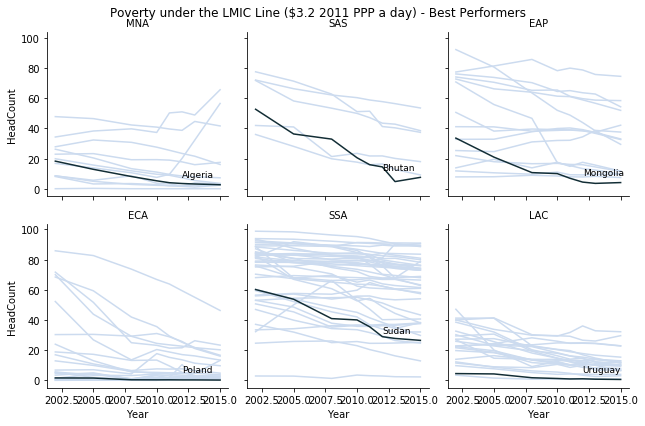

In [24]:
g = sns.FacetGrid(df, col='RegionCode', hue='RegionCode', col_wrap=3,col_order=col_order)
g = g.map(sns.lineplot,"Year","HeadCount", 'best', units=df.CountryName,estimator =None, palette="ch:2.5,.1")
g = g.set_titles(col_template="{col_name}")
#This for will add the name label of the best performer right aboove the poverty rate
for ax, country,location in zip(g.axes.flat, best_performers,best_performers_location):
    location = location + 5
    ax.text(2012, location,country, fontsize=9) #add text
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Poverty under the LMIC Line ($3.2 2011 PPP a day) - Best Performers ')
